In [1]:
%matplotlib inline

GMAT_PATH = '/home/daniel/gmat/GMAT/R2022a/'
import sys
sys.path.append(f'{GMAT_PATH}/api/')
from load_gmat import *

import json

import numpy as np
import matplotlib.pyplot as plt
from astroquery.jplhorizons import Horizons
import astropy.units as u
from astropy.time import Time
import scipy.optimize
import scipy.constants
plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
x = np.fromfile('SLIM_2024-01-19_14-51-51_19200SPS_PLL.c64', 'complex64')
t0 = np.datetime64('2024-01-19T14:51:51')
fs = 19200
NFFT = 2048
w = np.blackman(NFFT)
f = np.fft.fftshift(np.abs(np.fft.fft(w * x[:x.size//NFFT*NFFT].reshape(-1, NFFT)))**2, axes=1)
tf = t0 + (NFFT / fs * 1e9) * np.arange(f.shape[0]) * np.timedelta64(1, 'ns')
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))

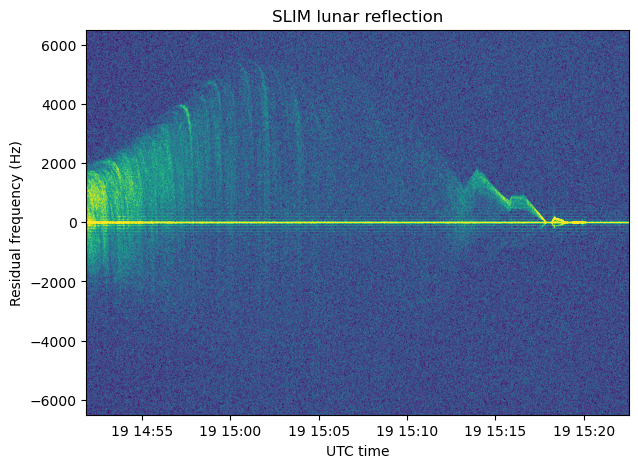

In [3]:
fsel = (faxis >= -6500) & (faxis <= 6500)
plt.figure(figsize=(7, 5))
plt.imshow(10*np.log10(f[:, fsel]).T[::-1], aspect='auto', vmin=-10, vmax=0,
           extent=[tf[0], tf[-1], faxis[fsel][0], faxis[fsel][-1]])
plt.xlabel('UTC time')
plt.ylabel('Residual frequency (Hz)')
plt.ylim((-6500, 6500))
plt.title('SLIM lunar reflection');

In [4]:
query = Horizons(
    id='SLIM', location='500@301', # Moon body center
    epochs={'start': '2024-01-19T14:50:00', 'stop': '2024-01-19T15:30:00', 'step': '2400'},
)
vectors = query.vectors(refplane='earth')

In [5]:
tv = (1e9 * Time(vectors['datetime_jd'], format='jd', scale='tdb').unix) * np.timedelta64(1, 'ns') + np.datetime64('1970-01-01T00:00')
tvsel = (tv >= tf[0]) & (tv <= tf[-1])
r_icrf = np.array([vectors[ax].to(u.km) for ax in 'xyz']).T
v_icrf = np.array([vectors[f'v{ax}'].to(u.km/u.s) for ax in 'xyz']).T

In [6]:
moon_fixed = gmat.Construct('CoordinateSystem', 'MoonFixed', 'Luna', 'BodyFixed')
moon_icrf = gmat.Construct('CoordinateSystem', 'MoonICRF', 'Luna', 'ICRF')
earth_fixed = gmat.Construct('CoordinateSystem', 'EarthFixed', 'Earth', 'BodyFixed')
csConverter = gmat.CoordinateConverter()
gmat.Initialize()
mjd = gmat.A1Mjd()
rvIn  = gmat.Rvector6()
rvOut = gmat.Rvector6()

In [7]:
r_body = np.empty_like(r_icrf)
v_body = np.empty_like(v_icrf)
earth_body = np.empty_like(r_icrf)
for j in range(r_icrf.shape[0]):
    rvIn.Set(*(list(r_icrf[j]) + list(v_icrf[j])))
    t_a1 = mjd.UtcMjdToA1Mjd(Time(tv[j]).jd - 2430000.0)
    csConverter.Convert(t_a1, rvIn, moon_icrf, rvOut, moon_fixed)
    rout = rvOut.GetDataVector()
    r_body[j] = rout[:3]
    v_body[j] = rout[-3:]
    rvIn.Set(*([0]*6))
    csConverter.Convert(t_a1, rvIn, earth_fixed, rvOut, moon_fixed)
    earth_body[j] = rvOut.GetDataVector()[:3]

In [8]:
r_body_abs = np.sqrt(np.sum(r_body**2, axis=1))

In [9]:
R_moon = 1737.4

In [10]:
alpha0 = np.empty(r_body.shape[0])
for j in range(alpha0.shape[0]):
    A = np.sqrt(np.sum(r_body[j]**2))
    B = np.sqrt(np.sum(earth_body[j]**2))
    phi = np.arccos(np.sum(r_body[j] * earth_body[j]) / (A * B))
    fun = lambda alpha: (np.cos(alpha) - R_moon/A)/np.sin(alpha) - (np.cos(phi - alpha) - R_moon/B)/np.sin(phi - alpha)
    alpha0[j] = scipy.optimize.bisect(fun, 1e-6, phi-1e-6)

In [11]:
earth_slim = earth_body - r_body
earth_slim_norm = earth_slim / np.sqrt(np.sum(earth_slim**2, axis=1))[:, np.newaxis]
r_body_abs = np.sqrt(np.sum(r_body**2, axis=1))
r_body_norm = r_body / r_body_abs[:, np.newaxis]
h = r_body_abs - R_moon
flat_model = h / np.tan(np.pi/2-np.arccos(np.sum(earth_slim_norm * r_body_norm, axis=1)))

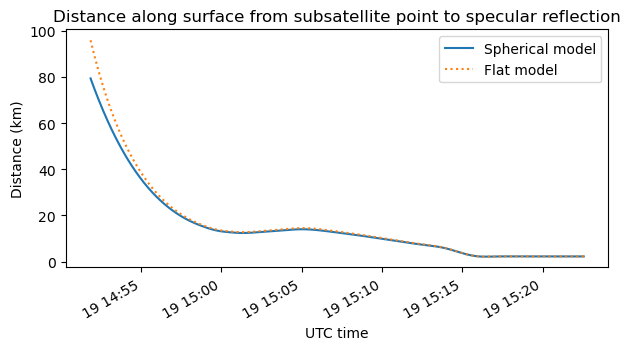

In [12]:
plt.plot(tv[tvsel], R_moon * alpha0[tvsel], label='Spherical model')
plt.plot(tv[tvsel], flat_model[tvsel], ':', label='Flat model')
plt.title('Distance along surface from subsatellite point to specular reflection')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)')
plt.legend()
plt.gcf().autofmt_xdate();

In [13]:
r_body_norm_perp = earth_slim_norm - np.sum(earth_slim_norm * r_body_norm, axis=1)[:, np.newaxis] * r_body_norm
r_body_norm_perp /= np.sqrt(np.sum(r_body_norm_perp**2, axis=1))[:, np.newaxis]
specular_body = R_moon * (np.cos(alpha0)[:, np.newaxis] * r_body_norm
                          + np.sin(alpha0)[:, np.newaxis] * r_body_norm_perp)
specular_slim = specular_body - r_body
specular_slim_norm = specular_slim / np.sqrt(np.sum(specular_slim**2, axis=1))[:, np.newaxis]

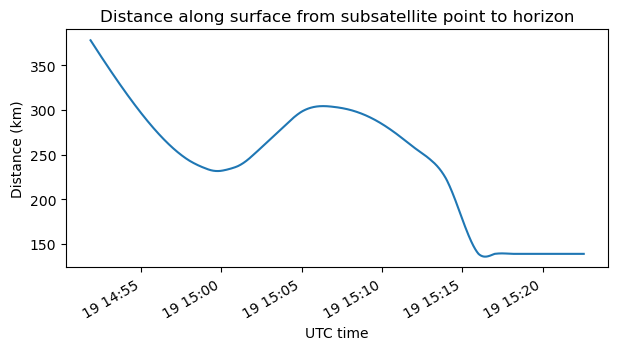

In [14]:
beta = np.arccos(R_moon / (h + R_moon))
plt.plot(tv[tvsel], R_moon * beta[tvsel])
plt.title('Distance along surface from subsatellite point to horizon')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)')
plt.gcf().autofmt_xdate();

In [15]:
# LVLH frame:
# X completes the orthonormal system, points in the direction of +v
# Y is normal to r and v, and is oriented to give a right-handed system
# Z points up (in the direction of +r)
lvlh_z = r_body_norm
lvlh_y = np.cross(r_body_norm, v_body)
lvlh_y /= np.sqrt(np.sum(lvlh_y**2, axis=1))[:, np.newaxis]
lvlh_x = np.cross(lvlh_y, lvlh_z)

In [16]:
horizon_body = R_moon * (np.cos(beta)[:, np.newaxis] * lvlh_z + np.sin(beta)[:, np.newaxis] * lvlh_x)
horizon_slim = horizon_body - r_body
horizon_slim_norm = horizon_slim / np.sqrt(np.sum(horizon_slim**2, axis=1))[:, np.newaxis]

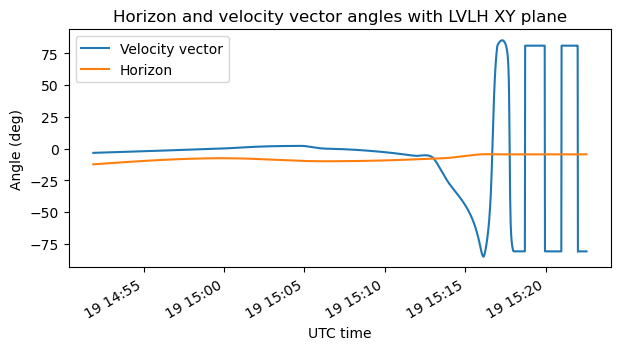

In [17]:
v_body_norm = v_body / np.sqrt(np.sum(v_body**2, axis=1))[:, np.newaxis]
v_angle = np.arcsin(np.sum(v_body_norm * lvlh_z, axis=1))
plt.plot(tv[tvsel], np.rad2deg(v_angle)[tvsel], label='Velocity vector')
plt.plot(tv[tvsel], np.rad2deg(-beta)[tvsel], label='Horizon')
plt.title('Horizon and velocity vector angles with LVLH XY plane')
plt.xlabel('UTC time')
plt.ylabel('Angle (deg)')
plt.legend()
plt.gcf().autofmt_xdate();

In [18]:
fcarrier = 2212e6
direct_doppler = fcarrier * np.sum(v_body * earth_slim_norm, axis=1) / scipy.constants.c * 1e3
specular_doppler = fcarrier * np.sum(v_body * specular_slim_norm, axis=1)  / scipy.constants.c * 1e3
max_doppler = fcarrier * np.sqrt(np.sum(v_body**2, axis = 1)) / scipy.constants.c * 1e3
horizon_doppler = fcarrier * np.sum(v_body * horizon_slim_norm, axis=1)  / scipy.constants.c * 1e3
max_doppler_ground = np.copy(max_doppler)
max_doppler_ground[v_angle > -beta] = horizon_doppler[v_angle > -beta]

In [19]:
earth_heading = np.angle(np.sum(earth_slim * (lvlh_x + 1j * lvlh_y), axis=1))

In [20]:
def horizon_body_heading(heading, timestamp):
    heading = np.deg2rad(heading)
    heading_vec = np.cos(heading) * lvlh_x + np.sin(heading) * lvlh_y
    hbh = R_moon * (np.cos(beta)[:, np.newaxis] * lvlh_z + np.sin(beta)[:, np.newaxis] * heading_vec)
    return hbh[timestamp]

def groundpoint_doppler(groundpoint):
    w = groundpoint - r_body
    w /= np.sqrt(np.sum(w**2, axis=1))[:, np.newaxis]
    w_mask = np.sum(groundpoint * lvlh_z, axis=1)/np.sqrt(np.sum(groundpoint**2)) > np.cos(beta)
    doppler = fcarrier * np.sum(v_body * w, axis=1)  / scipy.constants.c * 1e3
    doppler[~w_mask] = np.nan
    return doppler

def earth_elev_at_groundpoint(groundpoint):
    u = earth_body - groundpoint
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    w = groundpoint / np.sqrt(np.sum(groundpoint**2))
    return np.arcsin(np.sum(u * w, axis=1))

def slim_elev_at_groundpoint(groundpoint):
    u = r_body - groundpoint
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    w = groundpoint / np.sqrt(np.sum(groundpoint**2))
    return np.arcsin(np.sum(u * w, axis=1))

def groundpoint_heading(groundpoint):
    heading = np.angle(np.sum((groundpoint - r_body) * (lvlh_x + 1j * lvlh_y), axis=1))
    mask = slim_elev_at_groundpoint(groundpoint) < 0
    heading[mask] = np.nan
    return heading

def reflection_normal_angle(groundpoint):
    u = earth_body - groundpoint
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    v = groundpoint - r_body
    v /= np.sqrt(np.sum(v**2, axis=1))[:, np.newaxis]
    w = groundpoint / np.sqrt(np.sum(groundpoint**2))
    diff = u - v
    diff /= np.sqrt(np.sum(diff**2, axis=1))[:, np.newaxis]
    angle = np.arccos(np.sum(diff * w, axis=1))
    mask = slim_elev_at_groundpoint(groundpoint) < 0
    angle[mask] = np.nan
    return angle

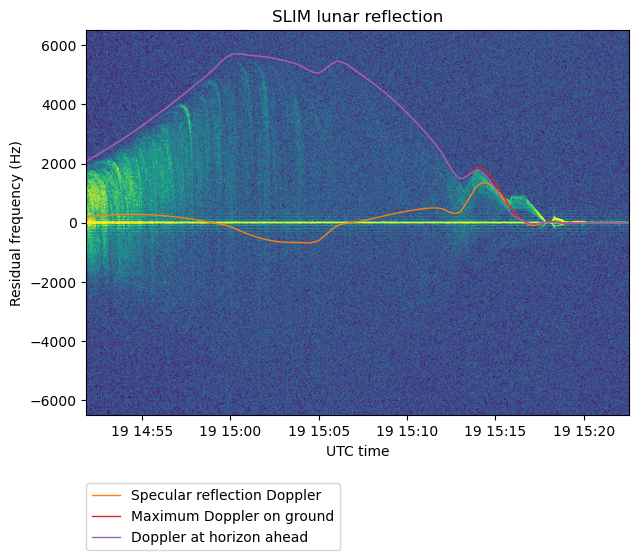

In [21]:
fsel = (faxis >= -6500) & (faxis <= 6500)
plt.figure(figsize=(7, 5))
plt.imshow(10*np.log10(f[:, fsel]).T[::-1], aspect='auto', vmin=-10, vmax=0,
           extent=[tf[0], tf[-1], faxis[fsel][0], faxis[fsel][-1]])
lw = 1
plt.plot(tv, specular_doppler - direct_doppler, label='Specular reflection Doppler', linewidth=lw, color='C1')
plt.plot(tv, max_doppler_ground - direct_doppler, label='Maximum Doppler on ground', linewidth=lw, color='C3')
plt.plot(tv, horizon_doppler - direct_doppler, label='Doppler at horizon ahead', linewidth=lw, color='C4')
plt.xlabel('UTC time')
plt.ylabel('Residual frequency (Hz)')
plt.ylim((-6500, 6500))
plt.title('SLIM lunar reflection')
plt.legend(loc=(0, -0.35));

In [22]:
def groundpoint_model(heading, timestamp, heading_error=0.5, timestamp_error=2):
    return {'p0': horizon_body_heading(heading, timestamp),
            'p0_minus': horizon_body_heading(heading+heading_error, timestamp-timestamp_error),
            'p0_plus': horizon_body_heading(heading-heading_error, timestamp+timestamp_error),
            'p0conj': horizon_body_heading(-heading, timestamp),
            'p0conj_minus': horizon_body_heading(-(heading+heading_error), timestamp-timestamp_error),
            'p0conj_plus': horizon_body_heading(-(heading-heading_error), timestamp+timestamp_error),
           }

def groundpoint_latlon(groundpoint):
    lat = np.arcsin(groundpoint[2]/R_moon)
    lon = np.angle(groundpoint[0] + 1j*groundpoint[1])
    return np.rad2deg(lat), np.rad2deg(lon)

def latlon_groundpoint_model(model):
    print(groundpoint_latlon(model['p0']))
    print(groundpoint_latlon(model['p0_minus']))
    print(groundpoint_latlon(model['p0_plus']))
    print(groundpoint_latlon(model['p0conj']))
    print(groundpoint_latlon(model['p0conj_minus']))
    print(groundpoint_latlon(model['p0conj_plus']))

In [23]:
geojson = {'type': 'FeatureCollection',
           'features': [],}

def add_to_geojson(model):
    for j, p in enumerate(model.values()):
        lat, lon = groundpoint_latlon(p)
        point = {'type': 'Feature',
                 'geometry': {
                     'type': 'Point',
                     'coordinates': [lon, lat],
                 },
                 'properties': None,
                 'id': j,
                }
        geojson['features'].append(point)

In [24]:
def plot_reflection_model(t0, t1, model):
    t0 = np.datetime64(t0)
    t1 = np.datetime64(t1)
    tsel = (tv >= t0) & (tv <= t1)
    tsel_ = (tf >= t0) & (tf <= t1)
    fsel = (faxis >= -6500) & (faxis <= 6500)
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True, height_ratios=[3, 1])
    axs[0].imshow(10*np.log10(f[tsel_][:, fsel]).T[::-1], aspect='auto', vmin=-10, vmax=0,
               extent=[tf[tsel_][0], tf[tsel_][-1], faxis[fsel][0], faxis[fsel][-1]])
    lw = 0.5
    axs[0].plot(tv[tsel], (groundpoint_doppler(model['p0']) - direct_doppler)[tsel],
                '-', color='white', linewidth=lw)
    axs[0].plot(tv[tsel], (groundpoint_doppler(model['p0_minus']) - direct_doppler)[tsel],
                '--', color='white', linewidth=lw)
    axs[0].plot(tv[tsel], (groundpoint_doppler(model['p0_plus']) - direct_doppler)[tsel],
                '--', color='white', linewidth=lw)
    axs[1].set_xlabel('UTC time')
    axs[0].set_ylabel('Residual frequency (Hz)')
    axs[0].set_ylim((-6500, 6500))
    lat, lon = groundpoint_latlon(model['p0'])
    axs[0].set_title(f'SLIM lunar reflection on '
                     f'{np.abs(lat):.3f}° {"N" if lat >= 0 else "S"} {np.abs(lon):.3f}° {"W" if lon < 0 else "E"}')
    axs[1].plot(tv[tsel], np.rad2deg(reflection_normal_angle(model['p0']))[tsel],
                label='Reflection normal angle')
    selev = np.rad2deg(slim_elev_at_groundpoint(model['p0']))
    selev[selev < 0] = np.nan
    axs[1].plot(tv[tsel], selev[tsel], label='SLIM elevation at groundpoint')
    axs[1].plot(tv[tsel], np.rad2deg(earth_elev_at_groundpoint(model['p0']))[tsel],
                label='Earth elevation at groundpoint')
    axs[1].plot(tv[tsel], np.rad2deg(earth_heading)[tsel], label='Earth heading')
    axs[1].plot(tv[tsel], np.rad2deg(groundpoint_heading(model['p0'])[tsel]), label='Groundpoint heading')
    axs[1].set_ylim(0, 60)
    axs[1].set_ylabel('Angle (deg)')
    axs[1].legend(loc=(0, -1.7))
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.05)

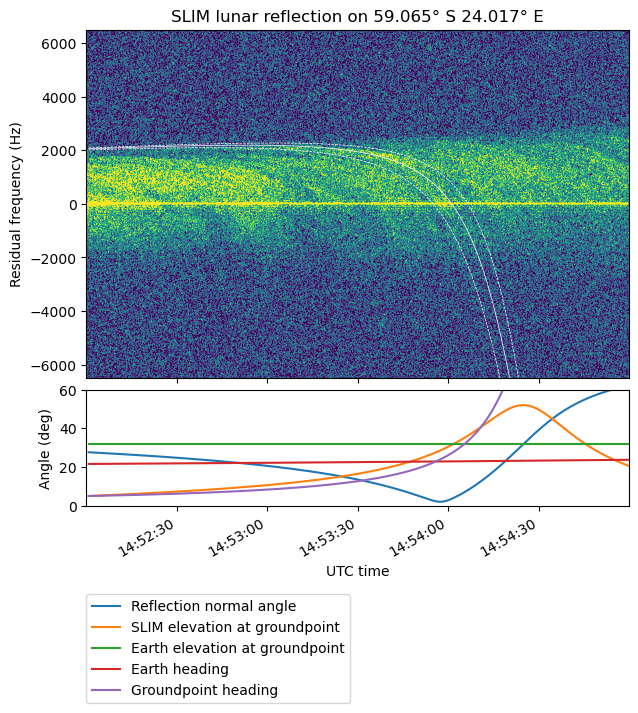

In [25]:
model = groundpoint_model(3, 91, heading_error=1, timestamp_error=3)
plot_reflection_model('2024-01-19T14:52', '2024-01-19T14:55', model)

In [26]:
latlon_groundpoint_model(model)
add_to_geojson(model)

(-59.065327382424066, 24.016893461560805)
(-59.19408649867781, 23.538300411302956)
(-58.9388099473149, 24.489039361419167)
(-59.065537022392775, 26.813759495542026)
(-59.19438437562402, 27.29308452714244)
(-58.93894057865982, 26.34088359109172)


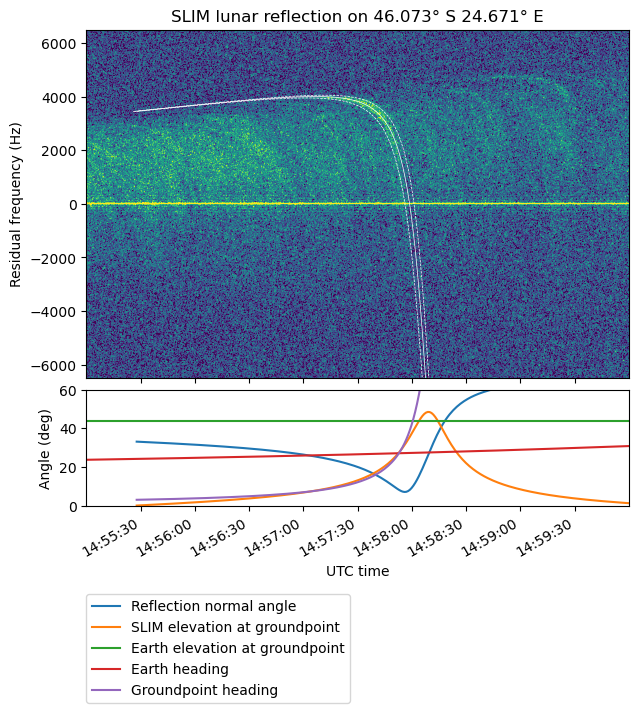

In [27]:
model = groundpoint_model(3, 396)
plot_reflection_model('2024-01-19T14:55', '2024-01-19T15:00', model)

In [28]:
latlon_groundpoint_model(model)
add_to_geojson(model)

(-46.073310442633414, 24.670793750011626)
(-46.16909918757512, 24.549286755759358)
(-45.97799052379505, 24.79132671809398)
(-46.07254016461112, 26.090978326255545)
(-46.16820522485377, 26.212939914902655)
(-45.97734530255639, 25.96999146922724)


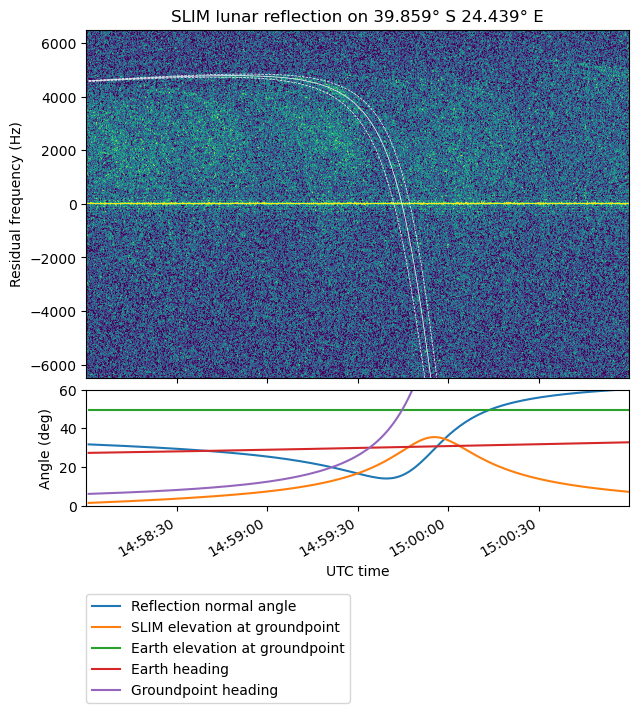

In [29]:
model = groundpoint_model(5, 525)
plot_reflection_model('2024-01-19T14:58', '2024-01-19T15:01', model)

In [30]:
latlon_groundpoint_model(model)
add_to_geojson(model)

(-39.859416929621936, 24.439270155960738)
(-39.96703057913081, 24.343664991461992)
(-39.752168246358686, 24.53428813140353)
(-39.85778706050864, 26.292944600758265)
(-39.96524294718649, 26.389035233248023)
(-39.75069712345334, 26.197441869943795)


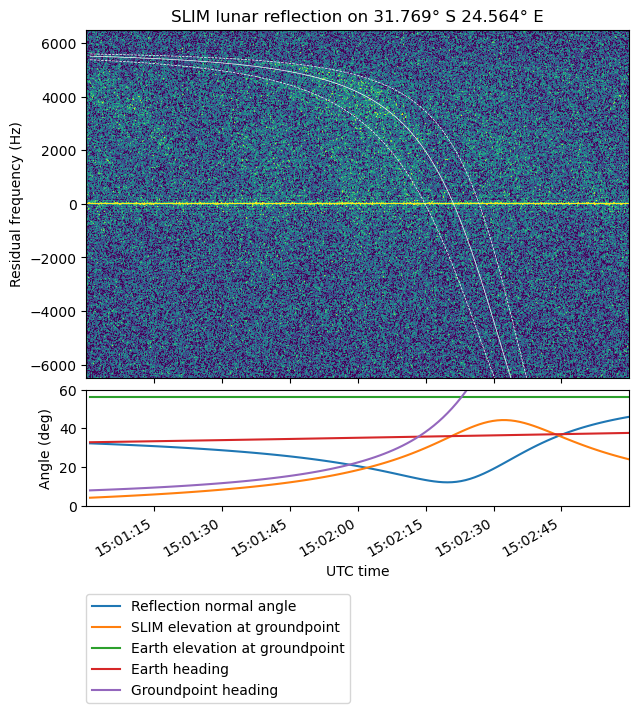

In [31]:
model = groundpoint_model(5, 673, heading_error=2, timestamp_error=3)
plot_reflection_model('2024-01-19T15:01', '2024-01-19T15:03', model)

In [32]:
latlon_groundpoint_model(model)
add_to_geojson(model)

(-31.769361958714782, 24.56403922091927)
(-31.961551369067617, 24.252019096041884)
(-31.586187073041284, 24.875970451438118)
(-31.767359049333933, 26.129077129882447)
(-31.958778396262336, 26.443606545635696)
(-31.584971682313082, 25.814552902389796)


In [33]:
with open('/tmp/points.json', 'w') as fjson:
    json.dump(geojson, fjson)